<a href="https://colab.research.google.com/github/abdumhmd/Facial-Emotion/blob/main/Fixed_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install keras-video-generators

# Most Recent One (Suggested)
!pip3 install git+https://github.com/rcmalli/keras-vggface.git
# Release Version
!pip3 install keras_vggface

  Created wheel for keras-video-generators: filename=keras_video_generators-1.0.14-py3-none-any.whl size=12881 sha256=2e22bfde1a951b3b6e31c2a0e1e377864ee5c2540473dfee7c69f6c98b4a8a04
  Stored in directory: /root/.cache/pip/wheels/bc/22/94/eda4e8caf00c0ffd3030fecbf2e0334b8a7f038f4451e20b00
Successfully built keras-video-generators
  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-b5a6sxqr
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-b5a6sxqr
  Created wheel for keras-vggface: filename=keras_vggface-0.6-py3-none-any.whl size=8325 sha256=7381d2cdb59ed58c377e21f581589ff05efc09c7b4252fb8d53fdc6b35515eeb
  Stored in directory: /tmp/pip-ephem-wheel-cache-k9xnvpvh/wheels/08/df/86/0225d44647ab2256dbf1e006823288fe9cc86367a056e6ea2c
Successfully built keras-vggface


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
filename = "/usr/local/lib/python3.7/dist-packages/keras_video/generator.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('from keras.utils import Sequence', 'from tensorflow.keras.utils import Sequence'))

15227

In [4]:
import os
import glob
import tensorflow as tf
import tensorflow.keras as keras
from keras_video import VideoFrameGenerator,SlidingFrameGenerator
# use sub directories names as classes
classes = os.listdir('/content/drive/MyDrive/data1/')
print(classes)
classes.sort()
# some global params
SIZE = (224, 224)
CHANNELS = 3
NBFRAME = 11
BS = 8
# pattern to get videos and classes
glob_pattern='/content/drive/MyDrive/data1/{classname}/*.mp4'
# for data augmentation
data_aug = keras.preprocessing.image.ImageDataGenerator(
    zoom_range=.2,
    horizontal_flip=True,
    rotation_range=8,
    #width_shift_range=.2,
    #height_shift_range=.2
    )
# Create video frame generator
train = VideoFrameGenerator(
    classes=['8', '1', '10', '11', '6', '7'], 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
    split_val=.2, 
    split_test=0.2,
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    color_mode="rgb",
    transformation=data_aug,
    use_frame_cache=False)

['2', '3', '12', '5', '6', '13', '8', '1', '10', '4', '9', '7', '11']
class 1, validation count: 11, test count: 9, train count: 36
class 10, validation count: 26, test count: 21, train count: 87
class 11, validation count: 8, test count: 6, train count: 27
class 6, validation count: 16, test count: 12, train count: 52
class 7, validation count: 7, test count: 6, train count: 24
class 8, validation count: 34, test count: 27, train count: 111
Total data: 6 classes for 337 files for train


In [5]:
valid = train.get_validation_generator()

Total data: 6 classes for 102 files for validation


In [6]:
test = train.get_test_generator()

Total data: 6 classes for 81 files for test


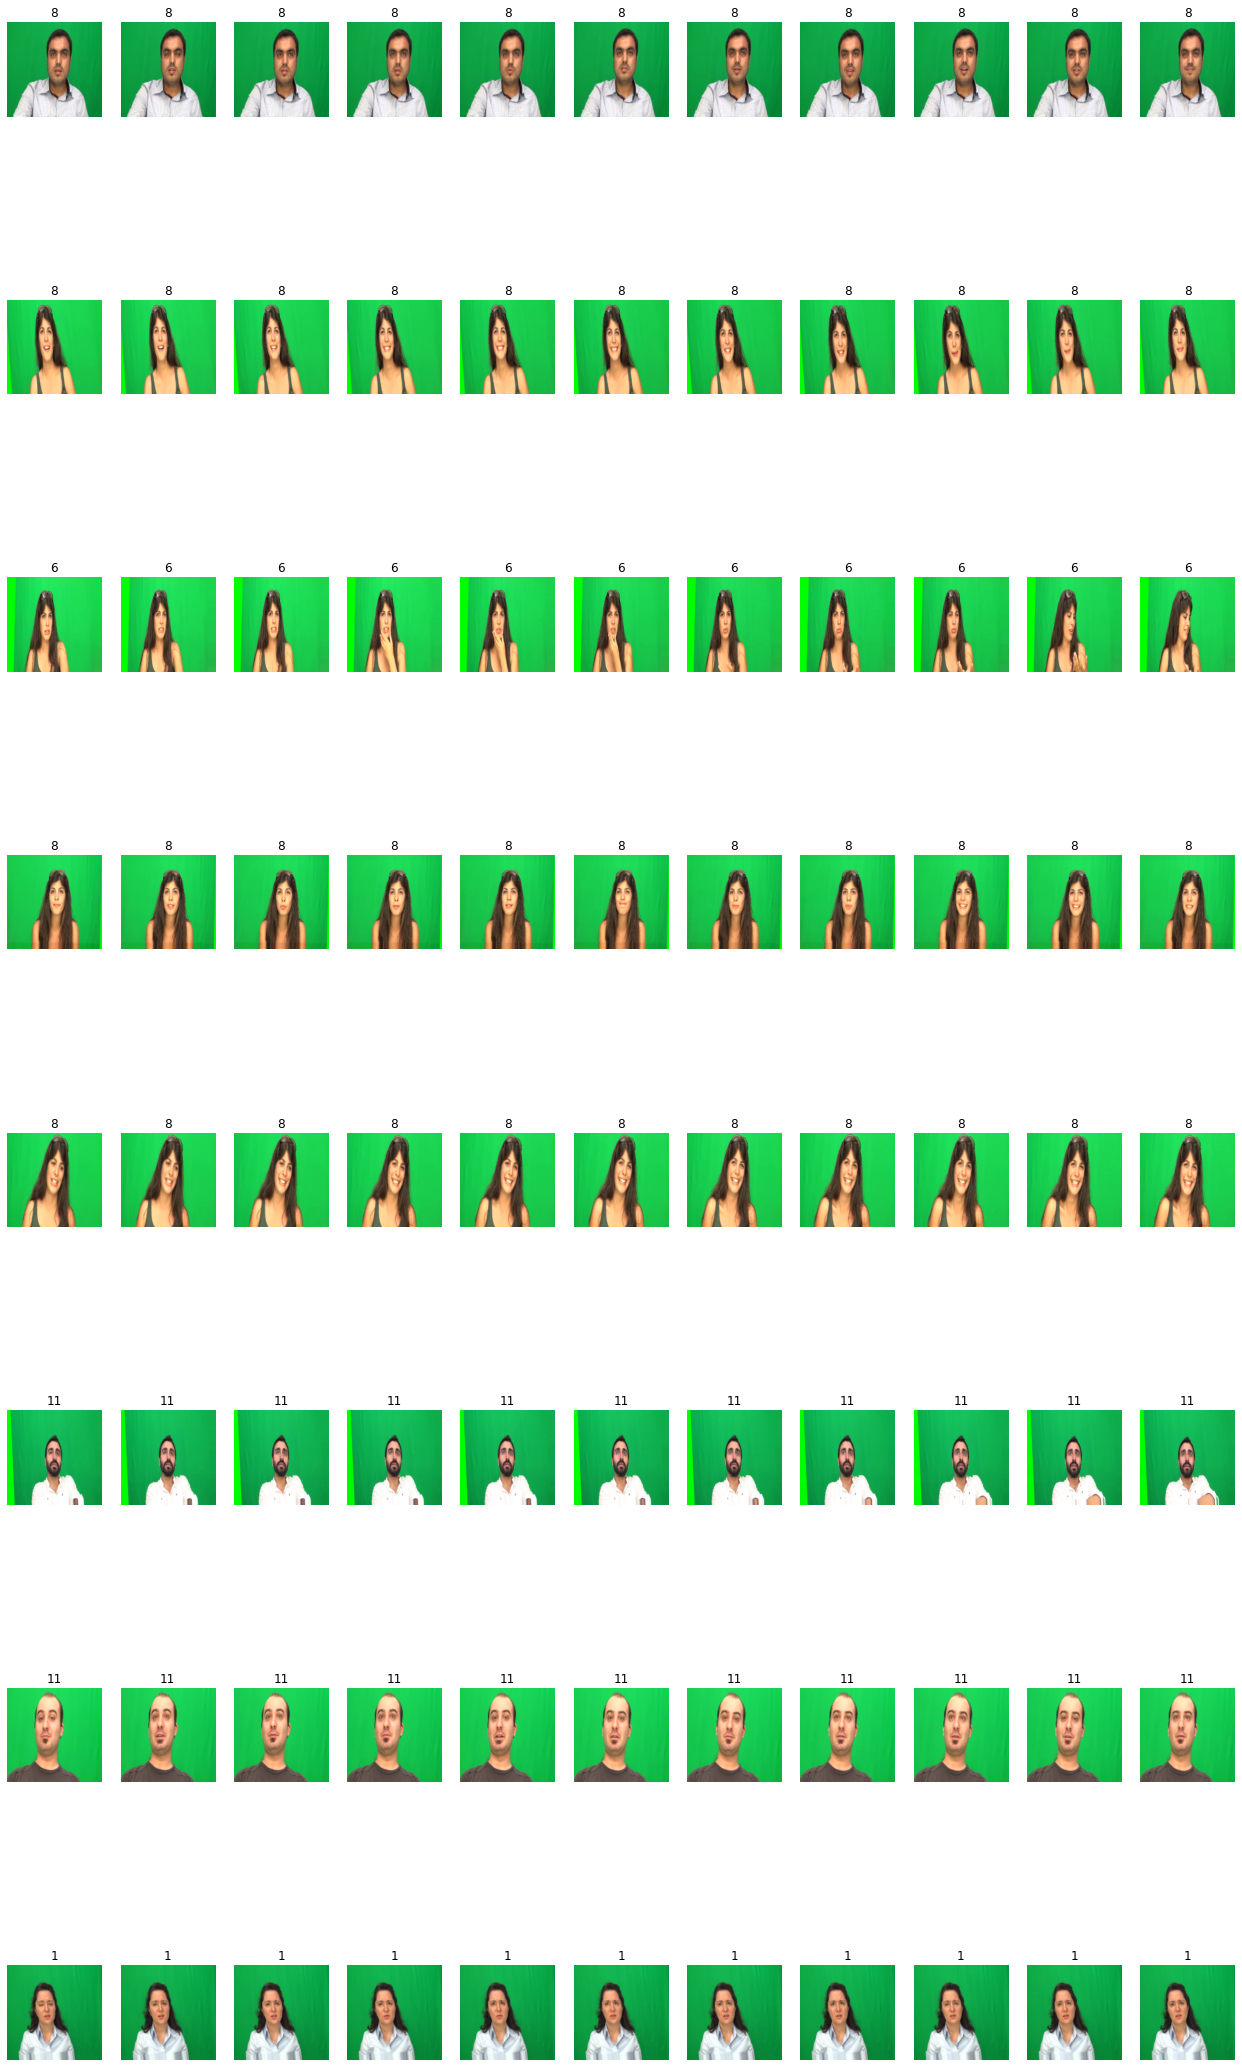

In [7]:
import keras_video.utils
keras_video.utils.show_sample(train)

In [8]:
import tensorflow as tf

filename = "/usr/local/lib/python3.7/dist-packages/keras_vggface/models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))

!pip install keras_applications
from keras_vggface.vggface import VGGFace


from keras.layers import Conv2D, Cropping2D,  BatchNormalization, MaxPool2D, GlobalMaxPooling2D
def build_mobilenet(shape=(224, 224,3), nbout=6):
    model = VGGFace(
        include_top=False,
        input_shape=shape,
        pooling='avg',
        weights='vggface')
    
    model=VGGFace(include_top=False, input_shape=(224, 224,3))
    model.trainable=False
    # Keep 9 layers to train﻿﻿
    #trainable = 9
    #for layer in model.layers[:-trainable]:
     #   layer.trainable = False
    #for layer in model.layers[-trainable:]:
     #   layer.trainable = True
    output = tf.keras.layers.Flatten()
    return keras.Sequential([model, output])

     |████████████████████████████████| 50 kB 5.4 MB/s 


In [14]:
# Set size to 224, 224
SIZE = (224, 224)
CHANNELS = 3
NBFRAME = 11
BS = 8

In [15]:
from keras.layers import TimeDistributed, GRU, LSTM, Dense, Dropout

def action_model(shape=(11, 224, 224,1), nbout=6):
    # Create our convnet with (224, 224, 3) input shape
    print(shape[1:])
    convnet = build_mobilenet(shape[1:])
    
    # then create our final model
    model = keras.Sequential()

    # add the convnet with (5, 112, 112, 3) shape
    model.add(TimeDistributed(convnet, input_shape=shape))
    # here, you can also use GRU or LSTM
    model.add(GRU(128))
    # and finally, we make a decision network
    
    model.add(Dense(64, activation='relu'))
  
    model.add(Dropout(0.5))
    model.add(Dense(32,activation='relu'))
    model.add(Dense(nbout, activation='softmax'))
    return model

In [16]:
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (6, 224, 224, 3)
print(INSHAPE)
model = action_model(INSHAPE,6)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
#model.load_weights('/content/drive/MyDrive/chkp/weights.01-1.23.hdf5')
model.compile(
    optimizer,
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=['acc']
)

(11, 224, 224, 3)
(224, 224, 3)


In [17]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDis  (None, 11, 25088)        14714688  
 tributed)                                                       
                                                                 
 gru_1 (GRU)                 (None, 128)               9683712   
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 6)                 198       
                                                      

In [18]:
EPOCHS=20
# create a "chkp" directory before to run that
# because ModelCheckpoint will write models inside
callbacks = [
    keras.callbacks.ReduceLROnPlateau(verbose=1,factor=0.1,patience=5),
   # keras.callbacks.ModelCheckpoint(
    #    '/content/drive/MyDrive/3frame_chkp/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
     #   save_best_only=True,
      #  verbose=1),
]
history=model.fit(
    train,
    validation_data=valid,
    verbose=1,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/20
42/42 [==============================] - 339s 8s/step - loss: 1.7144 - acc: 0.3214 - val_loss: 1.6018 - val_acc: 0.3229 - lr: 0.1000
Epoch 2/20
42/42 [==============================] - 48s 1s/step - loss: 1.6527 - acc: 0.3036 - val_loss: 1.6115 - val_acc: 0.3542 - lr: 0.1000
Epoch 3/20
42/42 [==============================] - 47s 1s/step - loss: 1.6331 - acc: 0.3214 - val_loss: 1.5925 - val_acc: 0.3646 - lr: 0.1000
Epoch 4/20
42/42 [==============================] - 46s 1s/step - loss: 1.5901 - acc: 0.3393 - val_loss: 1.5647 - val_acc: 0.4375 - lr: 0.1000
Epoch 5/20
42/42 [==============================] - 46s 1s/step - loss: 1.5932 - acc: 0.3839 - val_loss: 1.4612 - val_acc: 0.4688 - lr: 0.1000
Epoch 6/20
42/42 [==============================] - 47s 1s/step - loss: 1.5455 - acc: 0.3899 - val_loss: 1.5129 - val_acc: 0.4479 - lr: 0.1000
Epoch 7/20
42/42 [==============================] - 46s 1s/step - loss: 1.5335 - acc: 0.4167 - val_loss: 1.4098 - val_acc: 0.4792 - lr: 0.100

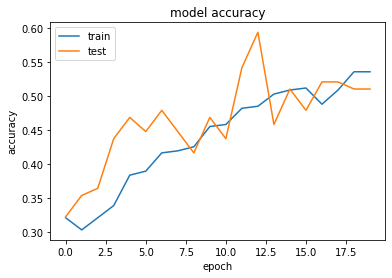

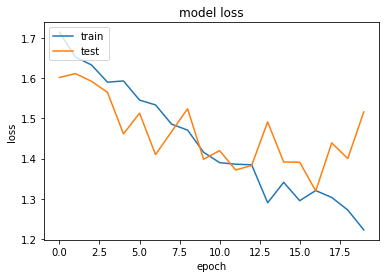

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
test=train.get_test_generator()
results = model.evaluate(test , verbose=2)
print("The Accuracy score on the Test set is:\t{:0.3f}".format(results[1]))

Total data: 6 classes for 81 files for test
10/10 - 28s - loss: 1.5593 - acc: 0.4750 - 28s/epoch - 3s/step
The Accuracy score on the Test set is:	0.475


In [34]:
from sklearn.metrics import classification_report
import numpy as np
y_test = []
y_predict = []
for x in range(train.__len__()):
    batch = train.__getitem__(x)[1]
    batch_predicted = model.predict(train.__getitem__(x)[0])

    for y in range(BS):
        y_test.append(batch[y])
        y_predict.append(batch_predicted[0])

y_test = np.argmax(y_test, axis=1)
y_predict = np.argmax(y_predict, axis=1)
con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_predict).numpy()
print(con_mat)
print(classification_report(y_test, y_predict))

[[ 0 13  0 12  0 11]
 [ 0 31  0 26  0 30]
 [ 0 11  0  9  0  6]
 [ 0 16  0 23  0 13]
 [ 0  7  0 11  0  6]
 [ 0 34  0 31  0 46]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        36
           1       0.28      0.36      0.31        87
           2       0.00      0.00      0.00        26
           3       0.21      0.44      0.28        52
           4       0.00      0.00      0.00        24
           5       0.41      0.41      0.41       111

    accuracy                           0.30       336
   macro avg       0.15      0.20      0.17       336
weighted avg       0.24      0.30      0.26       336



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
target_names=['Anger','Disgust','Fear','Happiness','Sadness','Surprise']

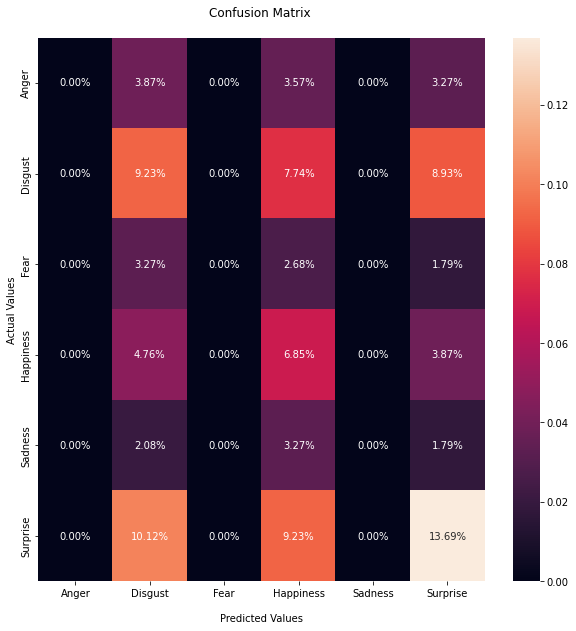

<Figure size 720x720 with 0 Axes>

In [36]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap((con_mat/np.sum(con_mat)), annot=True, 
            fmt='.2%', xticklabels=target_names, yticklabels=target_names)
ax.set_title('Confusion Matrix \n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values')
plt.figure(figsize=(10,10))
plt.show(block=False)